In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [2]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

## 클리닝

In [4]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [5]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [6]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

### 기존 리드타임 1< leadtime < 200

In [7]:
df = df[(df['리드타임'] > 1 ) & (df['리드타임'] < 150)]
df = df.dropna(subset=['창고입고'])

In [8]:
print(df[['발주', '창고입고']].head(), df['창고입고'].isnull().sum())

          발주       창고입고
0 2019-01-11 2019-05-03
1 2019-01-11 2019-04-18
2 2019-01-11 2019-05-03
5 2019-06-03 2019-06-15
6 2019-06-03 2019-06-15 0


### 날짜뽑기

> 연도는 숫자형으로 처리(새로운 연도에 대응)
> 나머지는 원핫인코딩

In [9]:
# 월(month), 요일(day of the week) 추출
df['month'] = df['창고입고'].dt.month
df['day_of_week'] = df['창고입고'].dt.dayofweek
df['year'] = df['창고입고'].dt.year

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['season'] = df['창고입고'].apply(get_season)

df = pd.get_dummies(df, columns=['month', 'day_of_week', 'season'], drop_first=True)


In [10]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name



In [11]:

text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

In [12]:
# Machinery별 평균 리드타임 계산
machinery_avg_leadtime = df.groupby('cleaned_machinery')['리드타임'].mean().reset_index()
machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_avg_leadtime'}, inplace=True)

# 데이터프레임에 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='cleaned_machinery', how='left')

In [13]:
# Machinery & Assembly 조합별 평균 리드타임 계산
df['machinery_assembly'] = df['cleaned_machinery'] + " & " + df['cleaned_assembly']
assembly_machinery_avg_leadtime = df.groupby('machinery_assembly')['리드타임'].mean().reset_index()
assembly_machinery_avg_leadtime.rename(columns={'리드타임': 'machinery_assembly_avg_leadtime'}, inplace=True)

# 데이터프레임에 Machinery & Assembly 조합의 평균 리드타임 추가
df = df.merge(assembly_machinery_avg_leadtime, on='machinery_assembly', how='left')


In [14]:
# 발주처별 평균 리드타임 계산 (cleaned_supplier 사용)
supplier_leadtime_avg = df.groupby('cleaned_supplier')['리드타임'].mean().reset_index()
supplier_leadtime_avg.rename(columns={'리드타임': 'supplier_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 발주처별 평균 리드타임 추가 (cleaned_supplier로 병합)
df = df.merge(supplier_leadtime_avg, on='cleaned_supplier', how='left')


In [15]:
# 발주처별 + Machinery 조합별 평균 리드타임 계산
supplier_machinery_leadtime = df.groupby(['cleaned_supplier', 'cleaned_machinery'])['리드타임'].mean().reset_index()
supplier_machinery_leadtime.rename(columns={'리드타임': 'supplier_machinery_avg_leadtime'}, inplace=True)

# 원본 데이터프레임에 병합
df = df.merge(supplier_machinery_leadtime, on=['cleaned_supplier', 'cleaned_machinery'], how='left')

In [36]:
df[['Machinery','Assembly','리드타임', '발주처', 'machinery_avg_leadtime','machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']].tail(20)

,Machinery,Assembly,리드타임,발주처,machinery_avg_leadtime,machinery_assembly_avg_leadtime,supplier_machinery_avg_leadtime
17500,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17501,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17502,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17503,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17504,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17505,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17506,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17507,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,61,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17508,7M NET BOAT ENGINE,FIG.11 EXHAUST MANIFOLD,21,"PORT RELIEF ENGINEERING CO.,LTD.",37.253131,25.647059,21.185009
17509,6M NET BOAT ENGINE,FIG 39. COOLER(FRESH WATER),21,"PORT RELIEF ENGINEERING CO.,LTD.",51.229584,24.722222,23.058043


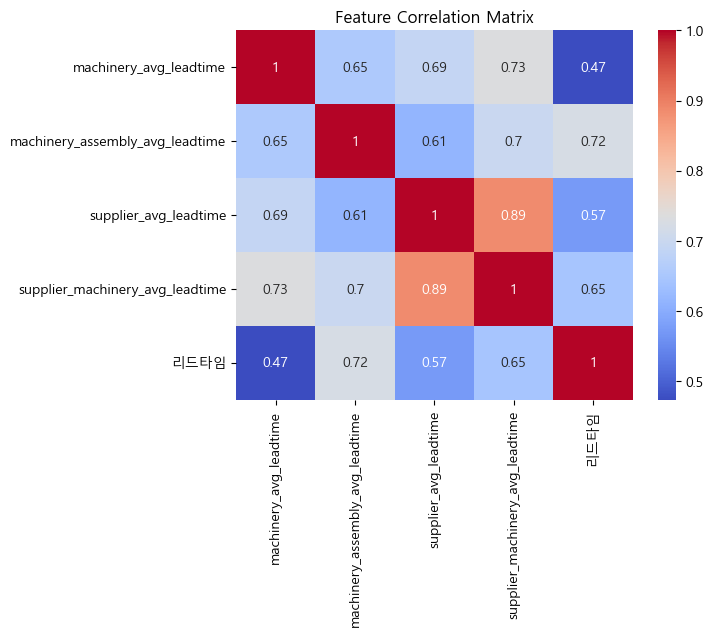

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피처 간 상관관계 계산 및 시각화
correlation_matrix = df[['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 
                         'supplier_avg_leadtime', 'supplier_machinery_avg_leadtime', '리드타임']].corr()
plt.rcParams['font.family']='Malgun Gothic'

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 word2vec
2. 수치형 데이터 Scaling
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

In [18]:
from scipy.stats import boxcox

X = df.drop(columns=['리드타임'])
y = df['리드타임'].values


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

numerical_features = ['machinery_avg_leadtime', 'machinery_assembly_avg_leadtime', 'supplier_machinery_avg_leadtime']

scaler = MinMaxScaler()
X_train_numerical = scaler.fit_transform(X_train[numerical_features])
X_val_numerical = scaler.transform(X_val[numerical_features])
X_test_numerical = scaler.transform(X_test[numerical_features])



In [20]:

# 가중치 부여: 두 번째 칼럼인 'machinery_assembly_avg_leadtime'에 2배 가중치 적용
X_train_numerical[:, 1] *= 2
X_val_numerical[:, 1] *= 2
X_test_numerical[:, 1] *= 2

# 결과 확인
print(f"X_train_numerical with weight applied: {X_train_numerical[:5]}")

X_train_numerical with weight applied: [[0.38001997 0.4109589  0.47212402]
 [0.38001997 0.60294418 0.62354867]
 [0.26565975 0.64253098 0.13231041]
 [0.60513229 0.64764079 0.48570514]
 [0.36075826 0.53424658 0.46997288]]


In [21]:
currency_ohe = OneHotEncoder(sparse_output=False)
currency_train_encoded = currency_ohe.fit_transform(X_train[['견적화폐']])
currency_val_encoded = currency_ohe.transform(X_val[['견적화폐']])
currency_test_encoded = currency_ohe.transform(X_test[['견적화폐']])


In [22]:
from gensim.models import Word2Vec

machinery_sentences_train = [text.split() for text in X_train['cleaned_machinery']]
assembly_sentences_train = [text.split() for text in X_train['cleaned_assembly']]

machinery_sentences_val = [text.split() for text in X_val['cleaned_machinery']]
assembly_sentences_val  = [text.split() for text in X_val['cleaned_assembly']]

machinery_sentences_test = [text.split() for text in X_test['cleaned_machinery']]
assembly_sentences_test = [text.split() for text in X_test['cleaned_assembly']]

word2vec_machinery = Word2Vec(sentences=machinery_sentences_train, vector_size=100, window=5, min_count=1, workers=4)
word2vec_assembly = Word2Vec(sentences=assembly_sentences_train, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

machinery_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_train['cleaned_machinery']])
assembly_vectors_train = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_train['cleaned_assembly']])

machinery_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_val['cleaned_machinery']])
assembly_vectors_val = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_val['cleaned_assembly']])

machinery_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_machinery) for sentence in X_test['cleaned_machinery']])
assembly_vectors_test = np.array([sentence_vector(sentence.split(), word2vec_assembly) for sentence in X_test['cleaned_assembly']])


In [21]:
supplier_sentences = [text.split() for text in df['cleaned_supplier']]

word2vec_supplier = Word2Vec(sentences=supplier_sentences, vector_size=100, window=5, min_count=1, workers=4)

supplier_vectors = np.array([sentence_vector(sentence, word2vec_supplier) for sentence in supplier_sentences])
print(f"Word2Vec Supplier Shape: {supplier_vectors.shape}")


Word2Vec Supplier Shape: (18653, 100)


In [36]:
#word2vec_supplier.save('word2vec_supplier.model')

In [37]:
#word2vec_machinery.save('word2vec_machinery.model')
#word2vec_assembly.save('word2vec_assembly.model')

In [23]:
X_train_month_features = X_train.filter(like='month_').values
X_train_day_of_week_features = X_train.filter(like='day_of_week_').values
X_train_season_features = X_train.filter(like='season_').values
year_train = X_train['year'].values.reshape(-1, 1)

X_test_month_features = X_test.filter(like='month_').values
X_test_day_of_week_features = X_test.filter(like='day_of_week_').values
X_test_season_features = X_test.filter(like='season_').values
year_test = X_test['year'].values.reshape(-1, 1)

X_val_month_features = X_val.filter(like='month_').values
X_val_day_of_week_features = X_val.filter(like='day_of_week_').values
X_val_season_features = X_val.filter(like='season_').values
year_val = X_val['year'].values.reshape(-1, 1)

In [24]:
X_train_combined = np.hstack((
    X_train_numerical,  # 스케일링된 수치형 피처들
    X_train_month_features,  # 월 One-Hot-Encoding 피처
    X_train_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_train,  # 연도 숫자
    X_train_season_features,  # 계절 One-Hot-Encoding 피처
    currency_train_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_train,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_train  # Word2Vec 벡터화된 assembly 피처
))
# 테스트 데이터 결합
X_val_combined = np.hstack((
    X_val_numerical,  # 스케일링된 수치형 피처들
    X_val_month_features,  # 월 One-Hot-Encoding 피처
    X_val_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_val,  # 연도 숫자
    X_val_season_features,  # 계절 One-Hot-Encoding 피처
    currency_val_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_val,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_val  # Word2Vec 벡터화된 assembly 피처
))

# 테스트 데이터 결합
X_test_combined = np.hstack((
    X_test_numerical,  # 스케일링된 수치형 피처들
    X_test_month_features,  # 월 One-Hot-Encoding 피처
    X_test_day_of_week_features,  # 요일 One-Hot-Encoding 피처
    year_test,  # 연도 숫자
    X_test_season_features,  # 계절 One-Hot-Encoding 피처
    currency_test_encoded,  # 견적화폐 One-Hot-Encoding 피처
    machinery_vectors_test,  # Word2Vec 벡터화된 machinery 피처
    assembly_vectors_test  # Word2Vec 벡터화된 assembly 피처
))

In [25]:
print(X_val_combined.shape)

(1314, 228)


In [25]:
import pickle

with open('MinMaxScaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

### 데이터 분할


In [26]:
print(f"X_train shape: {X_train_combined.shape}")
print(f"X_train shape: {X_val_combined.shape}")
print(f"X_test shape: {X_test_combined.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14892, 228)
X_train shape: (1314, 228)
X_test shape: (1314, 228)
y_train shape: (14892,)
y_test shape: (1314,)
y_test shape: (1314,)


In [28]:
import lightgbm as lgb
from lightgbm import callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model_lgb = lgb.LGBMRegressor(
    objective='regression',
    metric='mae', 
    learning_rate=0.05,  
    num_leaves=30, 
    max_depth=8,  
    n_estimators=5000,  
    subsample=0.8,  
    colsample_bytree=0.7,  
    reg_alpha=0.1, 
    reg_lambda=0.1 
)

# 콜백 설정
callbacks = [
    callback.early_stopping(stopping_rounds=50),  
    callback.log_evaluation(period=1000)  
]

# 모델 학습
model_lgb.fit(
    X_train_combined, y_train,
    eval_set=[(X_val_combined, y_val)],  
    eval_metric='mae',
    callbacks=callbacks
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37576
[LightGBM] [Info] Number of data points in the train set: 14892, number of used features: 228
[LightGBM] [Info] Start training from score 58.985898
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	valid_0's l1: 6.08538
[2000]	valid_0's l1: 5.05966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3000]	vali

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
              metric='mae', n_estimators=5000, num_leaves=30,
              objective='regression', reg_alpha=0.1, reg_lambda=0.1,
              subsample=0.8)

In [29]:
y_pred = model_lgb.predict(X_test_combined)
y_pred = np.maximum(0, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error (MAE): 4.564897093081083
Root Mean Squared Error (RMSE): 12.217304556032573
Mean Squared Error (MSE): 149.26253061485428
R^2 Score: 0.9128269438961417


### 기존 1<리드타임<200 일때

> Mean Absolute Error (MAE): 5.402290372823216

> Root Mean Squared Error (RMSE): 15.153656625990125
 
> Mean Squared Error (MSE): 229.63330913841443
 
> R^2 Score: 0.9153701844128428

C:\Users\User\anaconda3\envs\ship\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


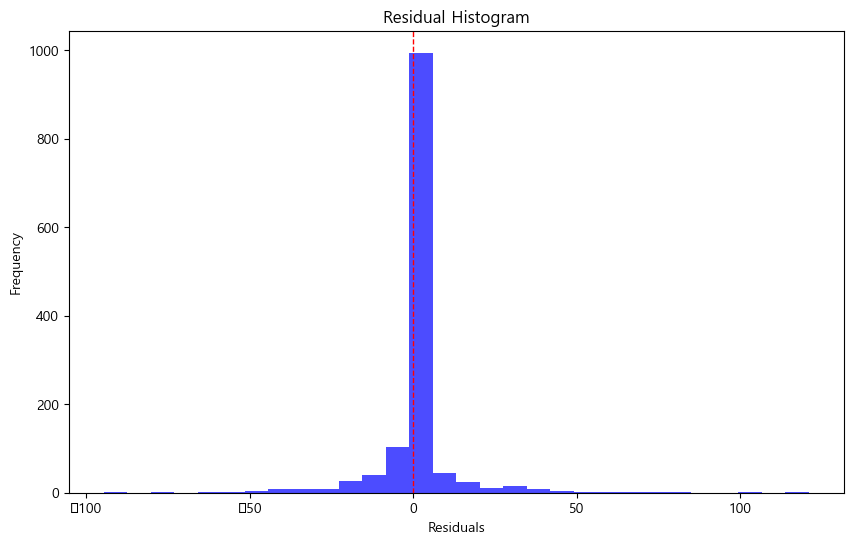

In [30]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)  
plt.show()

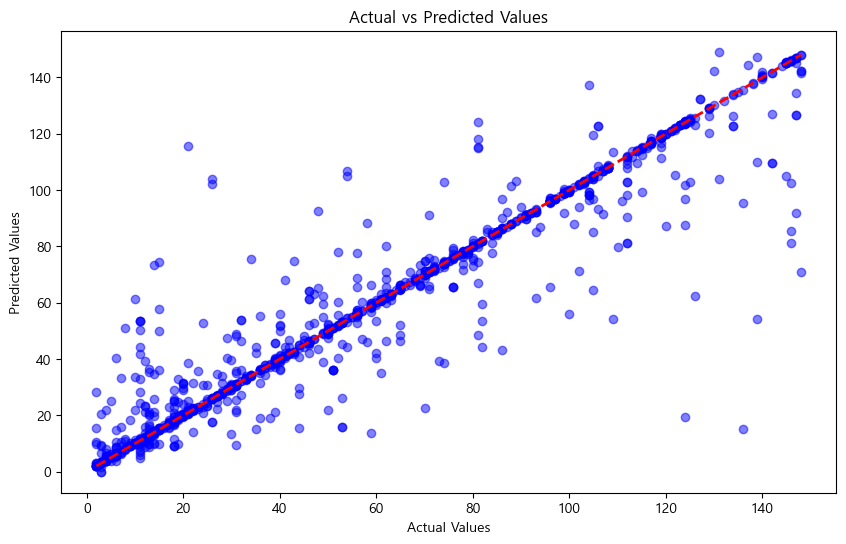

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [32]:

threshold = 50
residuals = y_test - y_pred
outliers = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
large_residuals = outliers[abs(outliers['Residual']) > threshold ] 
print(large_residuals)

      Actual   Predicted    Residual
37       126   62.536530   63.463470
310       54  105.158436  -51.158436
339       21  115.570914  -94.570914
451       14   73.250774  -59.250774
465      147   91.885152   55.114848
639       10   61.300704  -51.300704
686       26  102.204882  -76.204882
823      124   19.409209  104.590791
875      109   54.318382   54.681618
911       54  106.893466  -52.893466
984      146   81.175947   64.824053
1080      15   74.640388  -59.640388
1103     146   85.360824   60.639176
1110     136   15.124338  120.875662
1160      26  103.898118  -77.898118
1161     139   54.189791   84.810209
1207     148   70.964716   77.035284


In [33]:
y_test_df = pd.DataFrame(y_test, columns=['리드타임'])

large_residuals_indices = np.where(large_residuals > threshold)[0]

large_residuals_data = X_test.iloc[large_residuals_indices]
large_residuals_actual = y_test_df.iloc[large_residuals_indices]
large_residuals_predicted = y_pred[large_residuals_indices]

large_residuals_df = pd.DataFrame({
    'Actual': large_residuals_actual.values.flatten(),  
    'Predicted': large_residuals_predicted,
    'Residual': residuals[large_residuals_indices],
    'machinery_avg_leadtime': large_residuals_data['machinery_avg_leadtime'].values,
    'machinery_assembly_avg_leadtime': large_residuals_data['machinery_assembly_avg_leadtime'].values,
    'supplier_machinery_avg_leadtime': large_residuals_data['supplier_machinery_avg_leadtime'].values,
    'machinery' : large_residuals_data['Machinery'].values,
    'assembly' : large_residuals_data['Assembly'].values,
    'supplier' : large_residuals_data['발주처'].values
})

print(large_residuals_df.head(20))

    Actual   Predicted  Residual  machinery_avg_leadtime  \
0       33   33.049883 -0.049883               58.050000   
1       33   33.049883 -0.049883               58.050000   
2       33   33.049883 -0.049883               58.050000   
3       31   25.530348  5.469652               56.875088   
4       31   25.530348  5.469652               56.875088   
5       40   40.079282 -0.079282               40.473684   
6       10    9.916956  0.083044               56.875088   
7      108  107.868204  0.131796               56.875088   
8      108  107.868204  0.131796               56.875088   
9      108  107.868204  0.131796               56.875088   
10      46   46.397937 -0.397937               84.492308   
11      21   21.635727 -0.635727               37.253131   
12      93   93.344961 -0.344961               80.628627   
13      93   93.344961 -0.344961               80.628627   
14      40   40.079282 -0.079282               40.473684   
15      40   40.079282 -0.079282        